## <span style="color:white">Data Science Immersive Capstone Project</span>
### <span style="color:#CCC">Chris Huber, chrishubersf@gmail.com</span>
#### <span style="color:#AAA">A predictive classification study of edible wild mushrooms in the greater San Francisco Bay Area</span>

### <span style="color:white">Problem Statement</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>Given prior records of findings of edible wild edible mushroom species with latitude/longitude coordinates, species names, dates of sightings, weather conditions, and forest compositions can I predict for a given time period and location which species of edible mushroom an instance is likely to be among those that grow natively in the Bay Area?</p>
</div>

### <span style="color:white">Data Sources</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>
My main data source is a MySQL database dump that the curator for <a href="https://mushroomobserver.org">Mushroom Observer</a>, a user-submitted mushroom documenting website, released to me. I used <a href="http:/www.mykoweb.com">Mykoweb</a> for mushroom species classification details. I used the <a href="http://www.noaa.org">NOAA website</a> for weather data.
</p>
</div>

### <span style="color:white">Importing all Required Python Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MySQLdb
import math
import mplleaflet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

ss = StandardScaler()
skb = SelectKBest(f_classif, k=6)

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### <span style="color:white">Creating a MySQL Connection</span>

In [2]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='capstone', passwd='mushr0Om', 
                db='mushroom_observer')
mush_obsv_df = pd.read_sql('SELECT * from bay_area_observations;', con=mysql_cn)
mush_obsv_df = mush_obsv_df.set_index(['id'])
mush_names_df = pd.read_sql('SELECT * from bay_area_names;', con=mysql_cn)
mush_names_df = mush_names_df.set_index(['id'])
mush_locs_df = pd.read_sql('SELECT * from bay_area_locations;', con=mysql_cn)
mush_locs_df = mush_locs_df.set_index(['id'])

mush_locs_df.head(1)

version          created_at          updated_at  user_id  description_id  \
id                                                                             
21  3       2008-01-04 22:48:03 2010-08-14 01:56:45  1       NaN               

    rss_log_id  num_views           last_view    north   south     west  \
id                                                                        
21 NaN          219       2018-09-05 19:40:30  38.1464  38.039 -122.624   

       east  high  low  ok_for_export  \
id                                      
21 -122.486 NaN   NaN   1               

                                                                                                                                     notes  \
id                                                                                                                                           
21  [admin - Sat Aug 14 01:56:45 +0000 2010]: Changed location name from 'Novato, Marin Co., California, USA' to 'Novato, California, USA'   

                       name          scientific_name  locked  
id                                                            
21  Novato, California, USA  USA, California, Novato  0

### <span style="color:white">Defining lists to be used in filtering data</span>

In [3]:
choice_mushroom_list = ['Agaricus subrutilescens','Amanita novinupta','Boletus edulis','Boletus edulis var. grandedulis','Boletus regineus','Cantharellus californicus','Cantharellus cibarius','Cantharellus tubaeformis','Chlorophyllum brunneum','Clitocybe nuda','Lepista nuda','Coprinellus micaceus','Coprinus comatus','Entoloma medianox','Flammulina velutipes','Grifola frondosa','Hericium erinaceus','Himematsutake','Lactarius deliciosus','Lactarius rubidus','Lactarius rufulus','Leccinum manzanitae','Lentinula edodes','Morchella conica var. deliciosa','Morchella esculenta var. rotunda','Tremella fuciformis','Tricholoma matsutake','Tuber aestivum','Tuber birch','Tuber brumale','Tuber indicum','Tuber macrosporum','Tuber mesentericum','Volvariella volvacea']
edible_mushroom_list = ['Amanita caesarea','Amanita calyptroderma','Amanita velosa','Armillaria mellea','Auricularia auricula-judae','Gliophorus psittacinus','Hydnum repandum','Hypsizygus tessellatus/Hypsizygus marmoreus','Laccaria amethysteo-occidentalis','Suillus fuscotomentosus']
not_choice_mushroom_list = ['Agaricus augustus','Amanita augusta','Amanita sect. Vaginatae ','Amanita vaginata','Boletus badius','Calvatia gigantea','Clavaria fragilis','Gomphidius oregonensis','Gymnopus dryophilus','Lacrymaria lacrymabunda','Laetiporus gilbertsonii','Panaeolus papilionaceus','Pleurotus ostreatus','Pluteus cervinus','Suillus pungens','Volvopluteus gloiocephalus']

poisonous_mushroom_list = ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita amerimuscaria','Amanita gemmata','Amanita muscaria subsp. flavivolvata','Amanita phalloides','Amanita ocreata','Boletus eastwoodiae','Chlorophyllum molybdites','Galerina marginata','Hebeloma crustuliniforme','Hypholoma fasciculare','Inocybe geophylla','Leratiomyces ceres','Omphalotus olivascens','Suillellus amygdalinus']
psychoactive_mushroom_list = ['Gymnopilus luteofolius', 'Inocybe corydalina', 'Omphalotus olivascens', 'Panaeolus cinctulus', 'Panaeolus papilionaceus group', 'Psilocybe allenii', 'Psilocybe cyanescens']
other_mushroom_list = ['Amanita magniverrucata','Annulohypoxylon thouarsianum','Aureoboletus flaviporus','Bolbitius titubans','Caulorhiza umbonata','Clathrus ruber','Coprinellus sect. Micacei','Coprinopsis lagopus','Cortinarius glutinosoarmillatus','Cortinarius subgenus Telamonia','Entoloma subgenus Leptonia','Entoloma subgenus Nolanea','Ganoderma brownii','Gymnopilus luteofolius','Gymnopilus ventricosus','Helvella dryophila','Hericium coralloides','Hygrocybe acutoconica','Hygrocybe flavescens','Hygrocybe singeri','Hygrophorus eburneus','Phaeolus schweinitzii','Lactarius alnicola','Lactarius argillaceifolius var. megacarpus','Leratiomyces percevalii','Leucopaxillus albissimus','Marasmiellus candidus','Marasmius plicatulus','Mycena acicula','Mycena galericulata','Mycena haematopus','Mycena purpureofusca','Panus conchatus','Psathyrella candolleana','Psathyrella longipes','Psathyrella piluliformis','Russula cremoricolor','Russula sanguinaria','Russula sanguinea','Stereum hirsutum','Stropharia ambigua','Suillus caerulescens','Tremella aurantia','Tricholoma dryophilum','Tubaria furfuracea','Xylaria hypoxylon','Xylaria hypoxylon group']

### <span style="color:white">Defining dictionary of overlapping mushroom names to unify</span>

In [4]:
mush_merge_dict = {
    'Agaricus augustus group': 'Agaricus augustus',
    'Agaricus subrutilescens group': 'Agaricus subrutilescens',
    'Amanita novinupta group': 'Amanita novinupta',
    'Amanita vaginata group': 'Amanita vaginata',
    'Armillaria mellea group': 'Armillaria mellea',
    'Boletus edulis var. grandedulis': 'Boletus edulis',
    'Clavaria fragilis group': 'Clavaria fragilis',
    'Coprinellus micaceus group': 'Coprinellus micaceus',
    'Entoloma medianox f. eos': 'Entoloma medianox',
    'Flammulina velutipes group': 'Flammulina velutipes', 
    'Flammulina velutipes var. lupinicola': 'Flammulina velutipes', 
    'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
    'Gliophorus psittacinus group': 'Gliophorus psittacinus', 
    'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
    'Lactarius deliciosus group': 'Lactarius deliciosus',
    'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
    'Lepista nuda': 'Clitocybe nuda',
    'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
    'Pleurotus ostreatus group': 'Pleurotus ostreatus',
    'Pluteus cervinus group': 'Pluteus cervinus'
}

### <span style="color:white">Breaking Down Distribution Range Into Grid</span>
#### <span style="color:white">The plotted area is 134 miles N-S and 85 miles E-W</span>
#### <span style="color:white">Boundaries are 38.4228N - 364557N and 123.2710W - 121.5229W</span>
##### <span style="color:white">Breakdown into 1/4 miles squares</span>

In [116]:
def assign_grid(x):
    '''
    Assign grid code using the latitude and longitude of the original dataframe.
    '''
    lat_range = (38.4228 - 36.4557) / 275
    long_range = (-123.2710 - -121.5229) / 175
    # lat_range = (38.4228 - 36.4557) / 550
    # long_range = (-123.2710 - -121.5229) / 350
    
    return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4]) / long_range))

In [117]:
def mushroom_count_by_species(species_list):
    species_input = '|'.join(species_list)
    # query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude, IF(bay_area_locations.name LIKE '%redwoods%' OR bay_area_observations.notes LIKE '%redwood%', true, false) AS is_redwood, IF(bay_area_observations.notes LIKE '%douglas%' OR bay_area_observations.notes LIKE '%fir %' OR bay_area_observations.notes LIKE '%fir,%', true, false) AS is_fir, IF(bay_area_locations.name LIKE '%live oak%' OR bay_area_locations.name LIKE '%tanoak%' OR bay_area_observations.notes LIKE '%Quercus%', true, false) AS is_oak, IF(bay_area_observations.notes LIKE '%eucalyptus%', true, false) AS is_eucalyptus, IF(bay_area_observations.notes LIKE '%manzanita%', true, false) AS is_manzanita, IF(bay_area_observations.notes LIKE '%pine%', true, false) AS is_pine, IF(bay_area_observations.notes LIKE '%madrone%', true, false) AS is_madrone, IF(bay_area_observations.notes LIKE '%cypress%', true, false) AS is_cypress, IF(bay_area_observations.notes LIKE '%hardwood%', true, false) AS is_hardwood, IF(bay_area_observations.notes LIKE '%grass%', true, false) AS is_grass, IF(bay_area_observations.notes LIKE '%duff%', true, false) AS is_duff, IF(bay_area_observations.notes LIKE '%rott%', true, false) AS is_rott, IF(bay_area_observations.notes LIKE '%dung%', true, false) AS is_dung, IF(bay_area_observations.notes LIKE '%wood chip%', true, false) AS is_wood_chip FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude, IF(bay_area_locations.name LIKE '%redwoods%' OR bay_area_observations.notes LIKE '%redwood%', true, false) AS is_redwood, IF(bay_area_observations.notes LIKE '%douglas%' OR bay_area_observations.notes LIKE '%fir %' OR bay_area_observations.notes LIKE '%fir,%', true, false) AS is_fir, IF(bay_area_locations.name LIKE '%live oak%' OR bay_area_locations.name LIKE '%tanoak%' OR bay_area_observations.notes LIKE '%Quercus%', true, false) AS is_oak, IF(bay_area_observations.notes LIKE '%eucalyptus%', true, false) AS is_eucalyptus, IF(bay_area_observations.notes LIKE '%manzanita%', true, false) AS is_manzanita, IF(bay_area_observations.notes LIKE '%pine%', true, false) AS is_pine, IF(bay_area_observations.notes LIKE '%madrone%', true, false) AS is_madrone, IF(bay_area_observations.notes LIKE '%cypress%', true, false) AS is_cypress, IF(bay_area_observations.notes LIKE '%hardwood%', true, false) AS is_hardwood, IF(bay_area_observations.notes LIKE '%grass%', true, false) AS is_grass, IF(bay_area_observations.notes LIKE '%duff%', true, false) AS is_duff, IF(bay_area_observations.notes LIKE '%rott%', true, false) AS is_rott, IF(bay_area_observations.notes LIKE '%dung%', true, false) AS is_dung, IF(bay_area_observations.notes LIKE '%wood chip%', true, false) AS is_wood_chip, ROUND(stipe_max_length_cm - (stipe_max_length_cm - stipe_min_length_cm) * RAND(314), 1) AS stipe_length, ROUND(stipe_max_width_cm - (stipe_max_width_cm - stipe_min_width_cm) * RAND(314), 1) AS stipe_width, ROUND(pileus_max_width_cm - (pileus_max_width_cm - pileus_min_width_cm) * RAND(314), 1) AS pileus_width, stipe_shape, stipe_scales, lamellae_morph, pileus_shape, pileus_viscid, pileus_scales, pileus_warts, pileus_bruising FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id LEFT JOIN mushroom_stats ON bay_area_names.text_name = mushroom_stats.species WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"

    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    mush_by_species_df['text_name'] = mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x])
    mush_by_species_df['created_at'] = pd.to_datetime(mush_by_species_df['created_at'])
    return mush_by_species_df

edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
edible_by_species.head(5)

id          created_at          text_name   latitude   longitude  \
0  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
1   72344 2011-07-21 03:54:35  Agaricus augustus  37.551399 -122.334999   
2   81463 2011-11-05 02:27:01  Agaricus augustus  37.780701 -122.514000   
3  240031 2016-05-29 03:40:56  Agaricus augustus  37.074650 -122.109501   
4   59054 2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        0   
1           0       0       0              0             0        0   
2           0       0       0              0             0        0   
3           1       0       0              0             0        0   
4           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           1            0         0        0        0        0   
2           0           0            0         0        0        0        0   
3           0           0            0         0        0        0        0   
4           0           0            0         0        0        0        0   

   is_wood_chip  stipe_length  stipe_width  pileus_width stipe_shape  \
0             0          23.0          4.4          18.5       equal   
1             0          22.7          4.4          18.2       equal   
2             0          23.2          4.5          18.7       equal   
3             0          15.9          3.7          11.6       equal   
4             0          24.7          4.6          20.1       equal   

   stipe_scales lamellae_morph pileus_shape  pileus_viscid  pileus_scales  \
0             1          close          cap              0              1   
1             1          close          cap              0              1   
2             1          close          cap              0              1   
3             1          close          cap              0              1   
4             1          close          cap              0              1   

   pileus_warts  pileus_bruising grid_code  
0             0                1    147_92  
1             0                1    153_93  
2             0                1    185_75  
3             0                1    86_116  
4             0                1    74_121

In [118]:
len(edible_by_species)

2404

In [119]:
# edible_by_species.dtypes

### <span style="color:white">Function to create clusters using KMeans</span>

In [10]:
def create_clusters(mush_df, num_clusters=9):
    locs = mush_df[['latitude','longitude']]

    km = KMeans(n_clusters=num_clusters, random_state=314).fit(locs)
    regions = km.labels_
    centroids = km.cluster_centers_

    clustered_df = pd.concat([mush_df, pd.Series(regions, name='cluster')], axis=1)
    return clustered_df, centroids

clustered_mush, centroids = create_clusters(edible_by_species)
clustered_mush.head(2)
# clustered['cluster'].value_counts()

id          created_at          text_name   latitude   longitude  \
0  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
1  72344  2011-07-21 03:54:35  Agaricus augustus  37.551399 -122.334999   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0  0           0       0       0              0             0         
1  0           0       0       0              0             0         

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0  0           0           0            0         0        0        0         
1  0           1           0            0         0        0        0         

   is_wood_chip  stipe_length  stipe_width  pileus_width stipe_shape  \
0  0             23.0          4.4          18.5          equal        
1  0             22.7          4.4          18.2          equal        

   stipe_scales lamellae_morph pileus_shape  pileus_viscid  pileus_scales  \
0  1             close          cap          0              1               
1  1             close          cap          0              1               

   pileus_warts  pileus_bruising grid_code  cluster  
0  0             1                295_184   3        
1  0             1                306_187   5

### <span style="color:white">Saving results to .csv because KMeans keeps scrambling the cluster indexes</span>

In [142]:
# clustered_mush.to_csv('./data/saved_clustered_mush.csv', index=False)
clustered_mush = pd.read_csv('./data/saved_clustered_mush.csv')
clustered_mush['created_at'] = pd.to_datetime(clustered_mush['created_at'])

clustered_mush = clustered_mush.drop(['grid_code'], axis=1)
clustered_mush['grid_code'] = clustered_mush.apply(assign_grid, axis=1)
clustered_mush['grid_code'][0:20]

0      147_92
1      153_93
2      185_75
3      86_116
4      74_121
5      131_95
6      92_114
7      183_83
8      182_82
9      183_80
10     184_82
11     145_90
12    198_100
13    110_112
14    186_110
15     196_96
16    201_102
17     184_76
18    110_112
19     151_75
Name: grid_code, dtype: object

In [12]:
# clustered_mush.dtypes

### <span style="color:white">Adding Weather Data Scraped Using Selenium and Perform EDA</span>

In [143]:
def create_weather_data():
    weather_1_df = pd.read_csv('./data/w_San_Francisco.csv')
    weather_1_df['station'] = 1
    weather_2_df = pd.read_csv('./data/w_Sonoma.csv')
    weather_2_df['station'] = 2
    weather_3_df = pd.read_csv('./data/w_San_Jose.csv')
    weather_3_df['station'] = 3
    weather_4_df = pd.read_csv('./data/w_Santa_Cruz.csv')
    weather_4_df['station'] = 4
    weather_5_df = pd.read_csv('./data/w_Livermore.csv')
    weather_5_df['station'] = 5
    weather_6_df = pd.read_csv('./data/w_Berkeley.csv')
    weather_6_df['station'] = 6
    weather_7_df = pd.read_csv('./data/w_Monterey.csv')
    weather_7_df['station'] = 7

    w_df_station_list = [weather_1_df, weather_2_df, weather_3_df, weather_4_df, weather_5_df, 
                     weather_6_df, weather_7_df]

    w_all_df = pd.DataFrame(data=None, columns=['Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'])
    for i in range(0, len(w_df_station_list)):
        w_df_station_list[i].drop(['NewSnow', 'SnowDepth'], axis=1, inplace=True)
        w_all_df = w_all_df.append(w_df_station_list[i], ignore_index=True)

    ### replace missing values
    w_all_df = w_all_df.replace('M', 0)
    w_all_df['Precip'] = w_all_df['Precip'].replace('T', '0.001')
    
    ### fixing Date datatype
    w_all_df['Date'] = pd.to_datetime(w_all_df['Date'])
        
    return w_all_df

w_all_df = create_weather_data()
w_all_df.tail(2)

Date TMax TMin  TAvg  TDep HDD CDD Precip  station
31812 2018-09-29   71   55    63  -0.6   2   0   0.01      7.0
31813 2018-09-30   77   54  65.5     2   0   1      0      7.0

### <span style="color:white">Export Weather Data to .csv for MySQL import</span>

In [123]:
# w_all_df.to_csv('./data/bay_area_weather.csv', index=False)

### <span style="color:white">Plot Clusters</span>

In [124]:
centroids = pd.DataFrame(centroids, columns=['lat', 'long'])

In [125]:
cluster_dict = {
    0: 'North Bay', 1: 'Santa Cruz', 2: 'Livermore', 3: 'Peninsula', 4: 'San Francisco',
    5: 'Monterey', 6: 'Berkeley', 7: 'Watsonville', 8: 'San Jose'
}

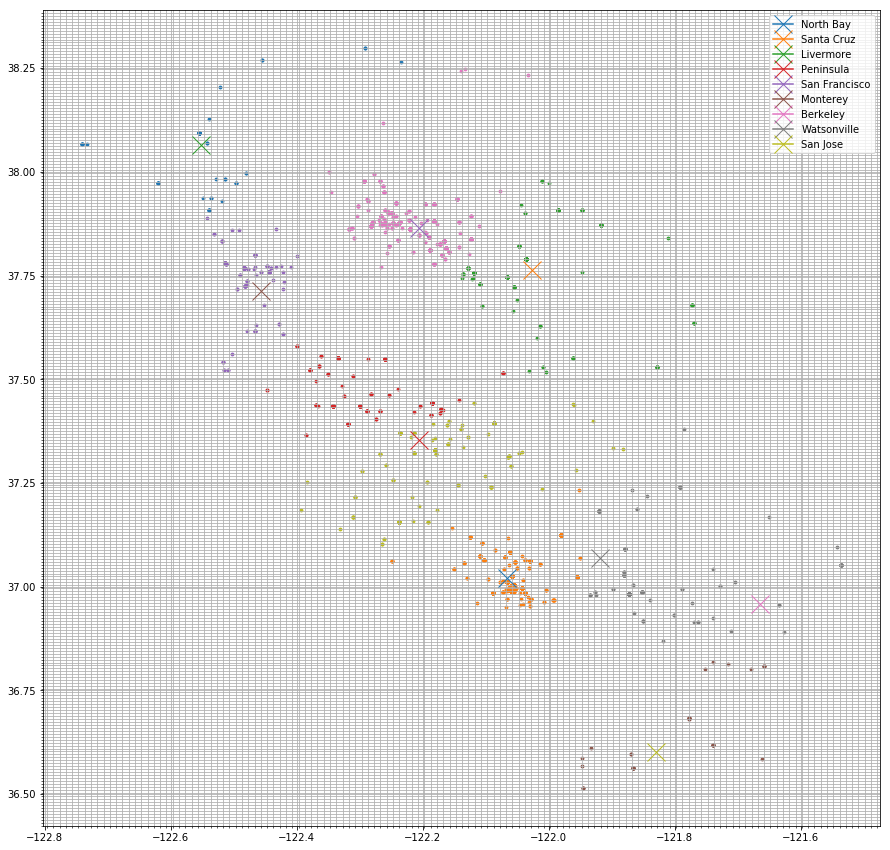

In [126]:
from matplotlib.ticker import MultipleLocator

def create_cluster_plot(mush_df, n=9):
    spacingy = (38.4228 - 36.4557) / 275
    spacingx = (123.2710 - 121.5229) / 175
    minorLocatorx = MultipleLocator(spacingx)
    minorLocatory = MultipleLocator(spacingy)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    ax.yaxis.set_minor_locator(minorLocatory)
    ax.xaxis.set_minor_locator(minorLocatorx)
    ax.grid(which = 'minor')
    
    for i in range(n):
        cluster = mush_df[mush_df['cluster'] == i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=8, cmap='viridis')
        c = centroids.iloc[i]
        plt.plot(c['long'], c['lat'], marker='x', markersize=18)
        plt.legend(cluster_dict.values())
    plt.grid()
create_cluster_plot(clustered_mush)


# cluster_dict = {
#     0: 'North Bay', 1: 'Santa Cruz', 2: 'Livermore', 3: 'Peninsula', 4: 'San Francisco',
#     5: 'Monterey', 6: 'Berkeley', 7: 'Watsonville', 8: 'San Jose'
# }

# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey
# cluster_map = {0:2, 1:1, 2:5, 3:3, 4:1, 5:7, 6:6, 7:7, 8:3}

In [127]:
def create_cluster_map(mush_df, n=9):
    fig, ax = plt.subplots(figsize=(15,15))
    x = edible_by_species['longitude']
    y = edible_by_species['latitude']

    for i in range(n):
        cluster = clustered_mush[clustered_mush['cluster']==i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=10, cmap='viridis')
        c = centroids.iloc[i]
        ax.plot(c['long'], c['lat'], marker='*', markersize=18)

    # plt.legend(cluster_dict.values())
    return mplleaflet.display(fig=fig)
    
create_cluster_map(clustered_mush)

In [144]:
# edible_by_species_clustered = pd.concat([edible_by_species, clustered_mush['cluster']],axis=1)
clustered_mush.head(2)

id          created_at          text_name   latitude   longitude  \
0  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
1   72344 2011-07-21 03:54:35  Agaricus augustus  37.551399 -122.334999   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        0   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           1            0         0        0        0        0   

   is_wood_chip  stipe_length  stipe_width  pileus_width stipe_shape  \
0             0          23.0          4.4          18.5       equal   
1             0          22.7          4.4          18.2       equal   

   stipe_scales lamellae_morph pileus_shape  pileus_viscid  pileus_scales  \
0             1          close          cap              0              1   
1             1          close          cap              0              1   

   pileus_warts  pileus_bruising  cluster grid_code  
0             0                1        3    147_92  
1             0                1        3    153_93

### Assign weather readings based on cluster number

In [145]:
### weather stations
# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey

# cluster_dict = {
#     0: 'Monterey', 1: 'Livermore', 2: 'Santa Cruz', 3: 'North Bay', 4: 'San Jose',
#     5: 'Berkeley', 6: 'Watsonville', 7: 'San Francisco', 8: 'Peninsula'
# }

def assign_cluster_data(row, col):
    cluster_map = {0:2, 1:1, 2:5, 3:3, 4:1, 5:7, 6:6, 7:7, 8:3}
    weather_date_str = str(row['created_at'])[0:10]
    
    return w_all_df[(w_all_df['Date'] == weather_date_str) & (w_all_df['station'] == cluster_map[row['cluster']])][col].values[0]
    
def assign_station_data(mush_df):
    edible_by_species_clustered_weather['TMax'] = 0
    edible_by_species_clustered_weather['TMin'] = 0
    edible_by_species_clustered_weather['Precip'] = 0

    weather_assign_cols = ['TMax', 'TMin', 'Precip']
    for col in weather_assign_cols:
        mush_df[col] = mush_df.apply(lambda row: assign_cluster_data(row, col), axis=1)

    return mush_df

edible_by_species_clustered_weather = clustered_mush.copy()
edible_by_species_clustered_weather = assign_station_data(edible_by_species_clustered_weather)
edible_by_species_clustered_weather.head(2)

id          created_at          text_name   latitude   longitude  \
0  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
1   72344 2011-07-21 03:54:35  Agaricus augustus  37.551399 -122.334999   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        0   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           1            0         0        0        0        0   

   is_wood_chip  stipe_length  stipe_width  pileus_width stipe_shape  \
0             0          23.0          4.4          18.5       equal   
1             0          22.7          4.4          18.2       equal   

   stipe_scales lamellae_morph pileus_shape  pileus_viscid  pileus_scales  \
0             1          close          cap              0              1   
1             1          close          cap              0              1   

   pileus_warts  pileus_bruising  cluster grid_code TMax TMin Precip  
0             0                1        3    147_92   66   53   0.00  
1             0                1        3    153_93   84   58   0.00

In [130]:
# edible_by_species_clustered_weather[edible_by_species_clustered_weather['TMax'] == 0]

### Replace numeric cluster names with meaningful labels

In [146]:
edible_by_species_clustered_weather = edible_by_species_clustered_weather.replace({'cluster': cluster_dict})
edible_by_species_clustered_weather.head(2)

id          created_at          text_name   latitude   longitude  \
0  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
1   72344 2011-07-21 03:54:35  Agaricus augustus  37.551399 -122.334999   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        0   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           1            0         0        0        0        0   

   is_wood_chip  stipe_length  stipe_width  pileus_width stipe_shape  \
0             0          23.0          4.4          18.5       equal   
1             0          22.7          4.4          18.2       equal   

   stipe_scales lamellae_morph pileus_shape  pileus_viscid  pileus_scales  \
0             1          close          cap              0              1   
1             1          close          cap              0              1   

   pileus_warts  pileus_bruising    cluster grid_code TMax TMin Precip  
0             0                1  Peninsula    147_92   66   53   0.00  
1             0                1  Peninsula    153_93   84   58   0.00

### <span style="color:white">Export to .csv for Tableau</span>

In [132]:
# edible_by_species_clustered_weather.to_csv('./data/edible_clustered_weather_named.csv', index=False)

### <span style="color:white">Fix non-numeric weather values</span>

In [147]:
edible_by_species_clustered_weather['Precip'] = edible_by_species_clustered_weather['Precip'].map(lambda x: str(x).rstrip('A'))
edible_by_species_clustered_weather['Precip'] = edible_by_species_clustered_weather['Precip'].replace('S', 0)

In [148]:
def make_weather_data_numeric(mush_df):
    # edible_clustered_train['created_at'][0].toordinal()
    mush_df['TMax'] = mush_df['TMax'].astype(int)
    mush_df['TMin'] = mush_df['TMin'].astype(int)
    mush_df['Precip'] = mush_df['Precip'].astype(float)
    
    return mush_df

edible_by_species_clustered_weather = make_weather_data_numeric(edible_by_species_clustered_weather)
# edible_by_species_clustered_weather.dtypes
# len(edible_by_species_clustered_weather)

### <span style="color:white">Reassigning temporal data based on month as string and year as continuous</span>

In [149]:
def alter_time_data(mush_df):
    # edible_clustered_weather_train['created_at'] = edible_clustered_train['created_at'].map(lambda x: x.toordinal())
    mush_df['month'] = mush_df['created_at'].map(lambda row: row.month).astype(str)
    mush_df['year'] = mush_df['created_at'].map(lambda row: row.year)
    mush_df = mush_df.drop(['created_at'], axis=1)
    
    return mush_df

edible_by_species_clustered_weather = alter_time_data(edible_by_species_clustered_weather)
# edible_clustered_weather_train.dtypes
# edible_by_species_clustered_weather.tail(10)

### <span style="color:white">Make train and test sets</span>

In [150]:
X = edible_by_species_clustered_weather.copy()
y = X['text_name']
# y = label_enc.fit_transform(X['text_name'])
# mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

### <span style="color:white">Running Several Different Models and SS/PCA Using Pipeline</span>

In [151]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
svc = SVC()
pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'rf_clf': rf_clf, 'svc': svc}

### initialize score dictionary
scores = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[('ss', ss), ('pca', pca), (model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.1, 2.0, 0.1)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [100, 150, 200]
        params['bag_clf__max_depth'] = [3, 4, 5, 6]
    elif (model_name) == 'rf_clf':
        params['rf_clf__n_estimators'] = np.arange(100, 200, 50)
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [20, 25, 30, 35, 40]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [100, 150, 200]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(30, 35, 40)
        params['svc__kernel'] = ['rbf']
        params['svc__gamma'] = ['auto']

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[2][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'log_reg': {'train_score': 0.89892984542211651,
  'best_params': {'log_reg__C': 1.9000000000000001, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=1.9000000000000001, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([-0.18317748,  0.83785424,  0.        , ...,  0.        ,
          0.        ,  0.        ]),
  'feature_importances': ''},
 'rf_clf': {'train_score': 0.78299643281807374,
  'best_params': {'rf_clf__max_depth': 40,
   'rf_clf__max_features': 'auto',
   'rf_clf__n_estimators': 150},
  'best_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=40, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min

In [152]:
pd.set_option('max_colwidth',1000)

model_names = list(scores.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict in scores.items():
    train_score.append(score_dict['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict['coefs'])
    feature_importances.append(score_dict['feature_importances'])

scores_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'best_estimator': best_estimator})
scores_df

best_estimator  \
0  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
1  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
2  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  coefs  \
0  [-0.183177476378, 0.837854238623, 0.0, 0.0, -0.525174302208, 0.0, 0.0566110445848, 0.158884394389, 0.407054412338, -0.393606187965, -0.278026989617, 0.0, 0.534242049281, -0.0911831620495, -0.673407681229, 0.0, 0.0, 0.0, 0.127981517305, 0.0, -0.17408639225, 0.145978519353, 0.0, 0.0570834636699, -0.23516480737, 0.0, 0.0, -0.185838983949, -0.168597650045, 0.0, 0.0, 0.499832189165, 0.0, -0.131573945725, 0.0, 0.0, 0.0, 0.0, -0.732156472465, 0.404028207687, 0.0361133590922, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

  regression model  train score  
0          log_reg     0.898930  
1           rf_clf     0.782996  
2              svc     0.718193

### <span style="color:white">Pipeline without PCA or StandardScaler</span>

In [153]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
# svc = SVC()
# pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'rf_clf': rf_clf, 'svc': svc}

### initialize score dictionary
scores2 = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[(model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.5, 9.5, 0.5)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (7, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__n_estimators'] = np.arange(100, 200, 50)
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [20, 25, 30, 35, 40]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(30, 35, 40)
        params['svc__kernel'] = ['rbf']
        params['svc__gamma'] = ['auto']

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[0][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores2[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores2

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'log_reg': {'train_score': 0.98335315101070153,
  'best_params': {'log_reg__C': 5.5, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=5.5, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'coefs': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'feature_importances': ''},
 'rf_clf': {'train_score': 0.95838287752675388,
  'best_params': {'rf_clf__max_depth': 30,
   'rf_clf__max_features': 'sqrt',
   'rf_clf__n_estimators': 100},
  'best_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=30, max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_jobs=1, oob_score=False, r

In [154]:
pd.set_option('max_colwidth', 1000)

model_names = list(scores2.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict2 in scores2.items():
    train_score.append(score_dict2['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict2['coefs'])
    feature_importances.append(score_dict2['feature_importances'])

scores2_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'feature importances': feature_importances})
scores2_df

coefs  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.272257837688, 0.0, -0.0604823618796, -0.00562368491061, 0.00506642414346, 0.0, -0.00553071774765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       feature importances  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1  [0.00407303617324, 0.000867344145987, 0.00115326152152, 0.00209683317223, 0.000620747560604, 0.00395283572064, 0.00124573332956, 0.00107292429715, 0.000714005651588, 0.00155383849834, 0.00128631273403, 0.00027085723923, 0.0010940921142, 0.00124

## <span style="color:white">Modeling</span>

### <span style="color:white">Copying dataframe to manipulate in models to avoid regenerating</span>

In [155]:
ebscw = edible_by_species_clustered_weather.copy()
# ebscw = ebscw[ebscw['text_name'].isin(choice_mushroom_list)]

### <span style="color:white">Adjust date-related columns</span>

In [156]:
# ebscw['Precip'] = ebscw['Precip'].map(lambda x: str(x).rstrip('A'))
# ebscw['Precip'] = ebscw['Precip'].replace('S', 0)

In [157]:
ebscw.head(2)

id          text_name   latitude   longitude  is_redwood  is_fir  \
0  318067  Agaricus augustus  37.512100 -122.349998           0       0   
1   72344  Agaricus augustus  37.551399 -122.334999           0       0   

   is_oak  is_eucalyptus  is_manzanita  is_pine  is_madrone  is_cypress  \
0       0              0             0        0           0           0   
1       0              0             0        0           0           1   

   is_hardwood  is_grass  is_duff  is_rott  is_dung  is_wood_chip  \
0            0         0        0        0        0             0   
1            0         0        0        0        0             0   

   stipe_length  stipe_width  pileus_width stipe_shape  stipe_scales  \
0          23.0          4.4          18.5       equal             1   
1          22.7          4.4          18.2       equal             1   

  lamellae_morph pileus_shape  pileus_viscid  pileus_scales  pileus_warts  \
0          close          cap              0              1             0   
1          close          cap              0              1             0   

   pileus_bruising    cluster grid_code  TMax  TMin  Precip month  year  
0                1  Peninsula    147_92    66    53     0.0     5  2018  
1                1  Peninsula    153_93    84    58     0.0     7  2011

In [158]:
# ebscw = make_weather_data_numeric(ebscw)
# ebscw = alter_time_data(ebscw)

### <span style="color:white">Removing Outliers</span>

In [159]:
# outliers = ['Hydnum repandum', 'Lentinula edodes', 'Amanita vaginata', 'Flammulina velutipes', 'Lactarius deliciosus']
# ebscw = ebscw[-ebscw['text_name'].isin(outliers)]

### <span style="color:white">Adding LabelEncoder</span>

In [160]:
label_enc = LabelEncoder()

def get_labels(le):
    '''
    Convenience function to return discrete ordered list of labels
    '''
    return le.classes_

def decode_labels(le, labelled_series):
    '''
    Returns species name from encoded label using fitted LabelEncoder instance
    '''
    decoded = le.inverse_transform(labelled_series)
    return decoded

### <span style="color:white">Functions to return top <i>n</i> probabilities for each row into new column</span>

In [161]:
def find_highest_probs(row, top_num=3):
    '''
    Returns top n highest probs into new row
    '''
    proba_list = row.nlargest(top_num)
    return ",".join(list(proba_list.index))

def get_probas_from_test(target, test_df, model, top_num=3):
    '''
    Returns df with top n species probabilities appended to each row (for each observation)
    '''
    probas = model.predict_proba(target)
    probas_df = pd.DataFrame(probas, index=test_df.index)
    probas_df.columns = mush_labels

    probas_df['proba_list'] = probas_df.T.apply(lambda row: find_highest_probs(row, top_num))
    
    return probas_df

### <span style="color:white">Functions to analyze predicted output</span>

In [162]:
def filter_preds_df(row):
    '''
    Mask to only return matching rows from predictions dataframe
    '''
    return row['actual'] in row['proba_list']

def analyze_preds(actuals, probas, test_df, le):
    '''
    Decodes target labels and returns matching rows for actual in predicted n species string
    '''
    actual_vals = decode_labels(le, actuals)
    preds_df = pd.DataFrame(data=None, index=X_test.index)
    preds_df['actual'] = pd.Series(decode_labels(le, actuals), index=X_test.index)
    preds_df['proba_list'] = pd.Series(probas['proba_list'], index=X_test.index)

    preds_df_filter = preds_df.apply(filter_preds_df, axis=1)
    matches = preds_df[preds_df_filter]
    
    return matches

### <span style="color:white">Function to output multiclass confusion matrix</span>

In [163]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    '''
    Sourced from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size='18', color='k')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True species', size='14', color='k')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), size='14', color='k')
    # plt.xlabel('Predicted species')
    plt.show()

### <span style="color:white">Running LogisticRegression without PCA/SS</span>

In [164]:
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

log_reg = LogisticRegression(C=6.0, penalty='l1')
log_reg.fit(X_train, y_train)

LogisticRegression(C=6.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [165]:
y_preds = log_reg.predict(X_test)
y_preds_lr = label_enc.inverse_transform(y_preds)

cross_val_score(log_reg, X_train, y_train), np.mean(cross_val_score(log_reg, X_train, y_train)), cross_val_score(log_reg, X_test, y_test), np.mean(cross_val_score(log_reg, X_test, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.97909408,  0.98389982,  0.98724954]),
 0.98341448079692306,
 array([ 0.96062992,  0.97916667,  0.97807018]),
 0.97262225445503514)

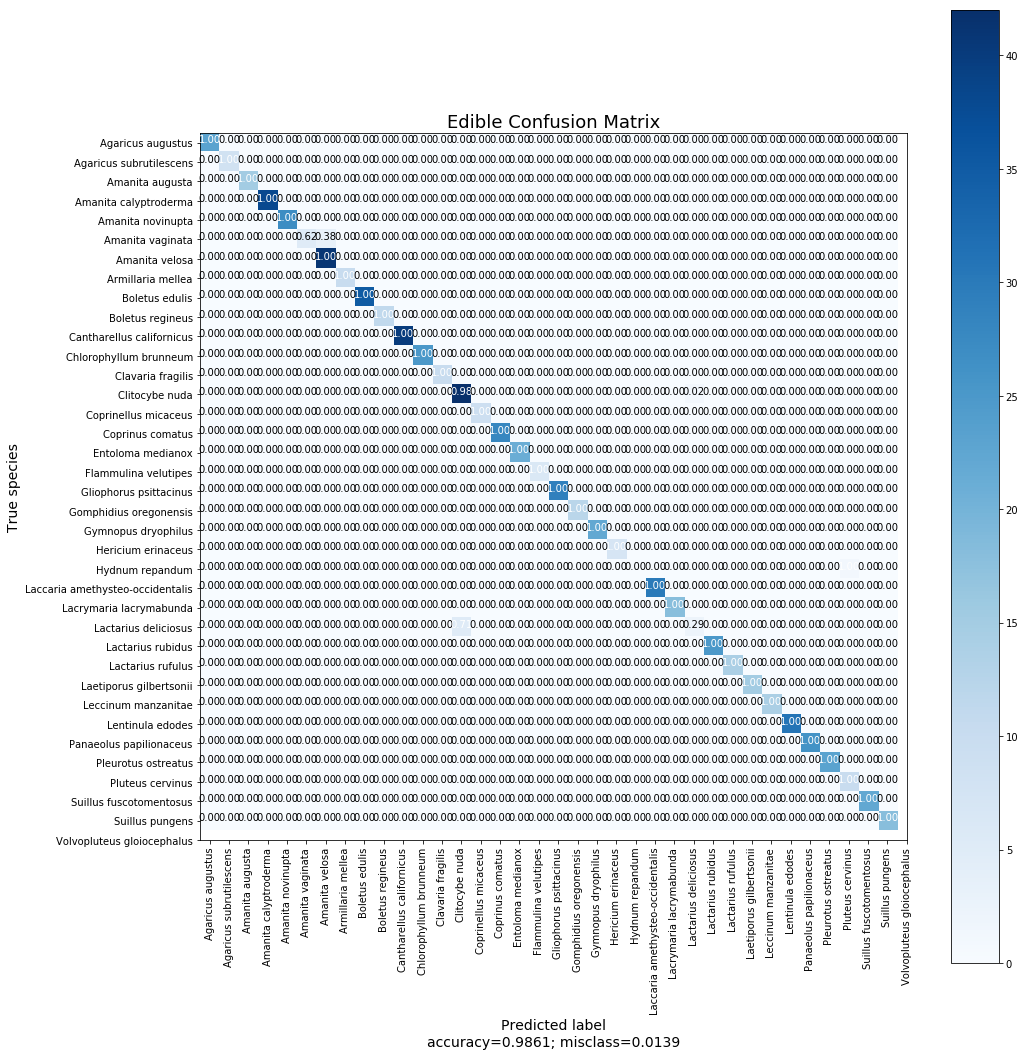

In [166]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)
plot_confusion_matrix(pca_cm, mush_labels, title='Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [85]:
probas_df = get_probas_from_test(X_test, X_test, log_reg)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(721, 0.9986149584487535)

### <span style="color:white">Running LogisticRegression and PCA</span>

In [88]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

log_reg = LogisticRegression(C=1.7, penalty='l1')
log_reg.fit(X_train_ss_pca, y_train)

LogisticRegression(C=1.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [89]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds = log_reg.predict(X_test_ss_pca)
y_preds_lr = label_enc.inverse_transform(y_preds)
cross_val_score(log_reg, X_train_ss_pca, y_train), np.mean(cross_val_score(log_reg, X_train_ss_pca, y_train)), cross_val_score(log_reg, X_test_ss_pca, y_test), np.mean(cross_val_score(log_reg, X_test_ss_pca, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.89372822,  0.91234347,  0.87249545]),
 0.89285571324848645,
 array([ 0.81496063,  0.85416667,  0.86842105]),
 0.84584944973983511)

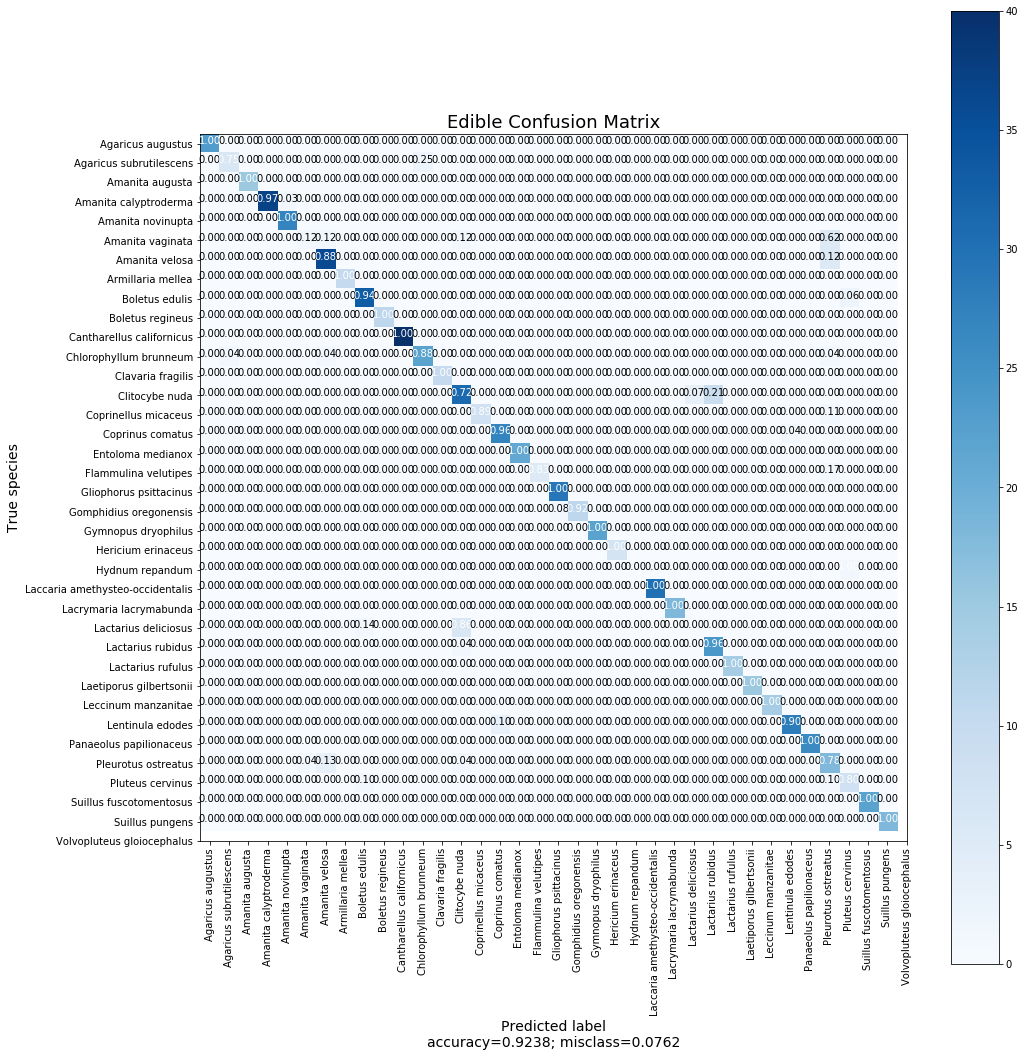

In [90]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)
plot_confusion_matrix(pca_cm, mush_labels, title='Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [91]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, log_reg)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(717, 0.9930747922437673)

### <span style="color:white">Running RandomForestClassifier without PCA</span>

In [92]:
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])

X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

rf_clf = RandomForestClassifier(n_estimators=150, max_depth=30, max_features='sqrt')
rf_clf.fit(X_train, y_train)

y_preds_rf = rf_clf.predict(X_test)
cross_val_score(rf_clf, X_train, y_train), np.mean(cross_val_score(rf_clf, X_train, y_train)), cross_val_score(rf_clf, X_test, y_test), np.mean(cross_val_score(rf_clf, X_test, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.95121951,  0.94454383,  0.95264117]),
 0.95121505022660846,
 array([ 0.91732283,  0.95      ,  0.94736842]),
 0.93545609430400145)

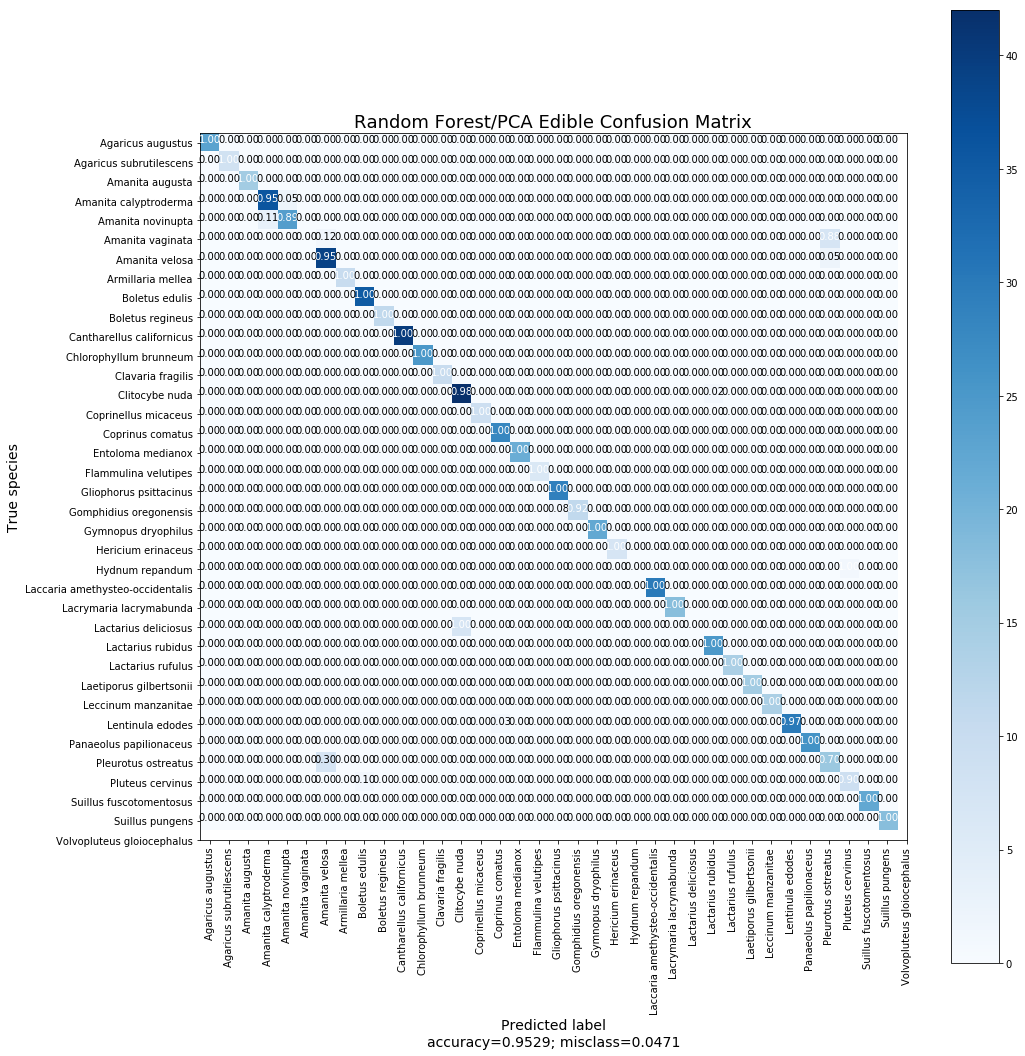

In [93]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_rf))
plot_confusion_matrix(pca_cm, mush_labels, title='Random Forest/PCA Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [95]:
probas_df = get_probas_from_test(X_test, X_test, rf_clf)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(719, 0.9958448753462604)

### <span style="color:white">Running RandomForestClassifier and PCA</span>

In [96]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])

X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

rf_clf = RandomForestClassifier(n_estimators=150, max_depth=25, max_features='sqrt')
rf_clf.fit(X_train_ss_pca, y_train)

X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_rf = rf_clf.predict(X_test_ss_pca)
cross_val_score(rf_clf, X_train_ss_pca, y_train), np.mean(cross_val_score(rf_clf, X_train_ss_pca, y_train)), cross_val_score(rf_clf, X_test_ss_pca, y_test), np.mean(cross_val_score(rf_clf, X_test_ss_pca, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.82752613,  0.80679785,  0.80510018]),
 0.81600296247460646,
 array([ 0.71653543,  0.72916667,  0.74561404]),
 0.73546185016346632)

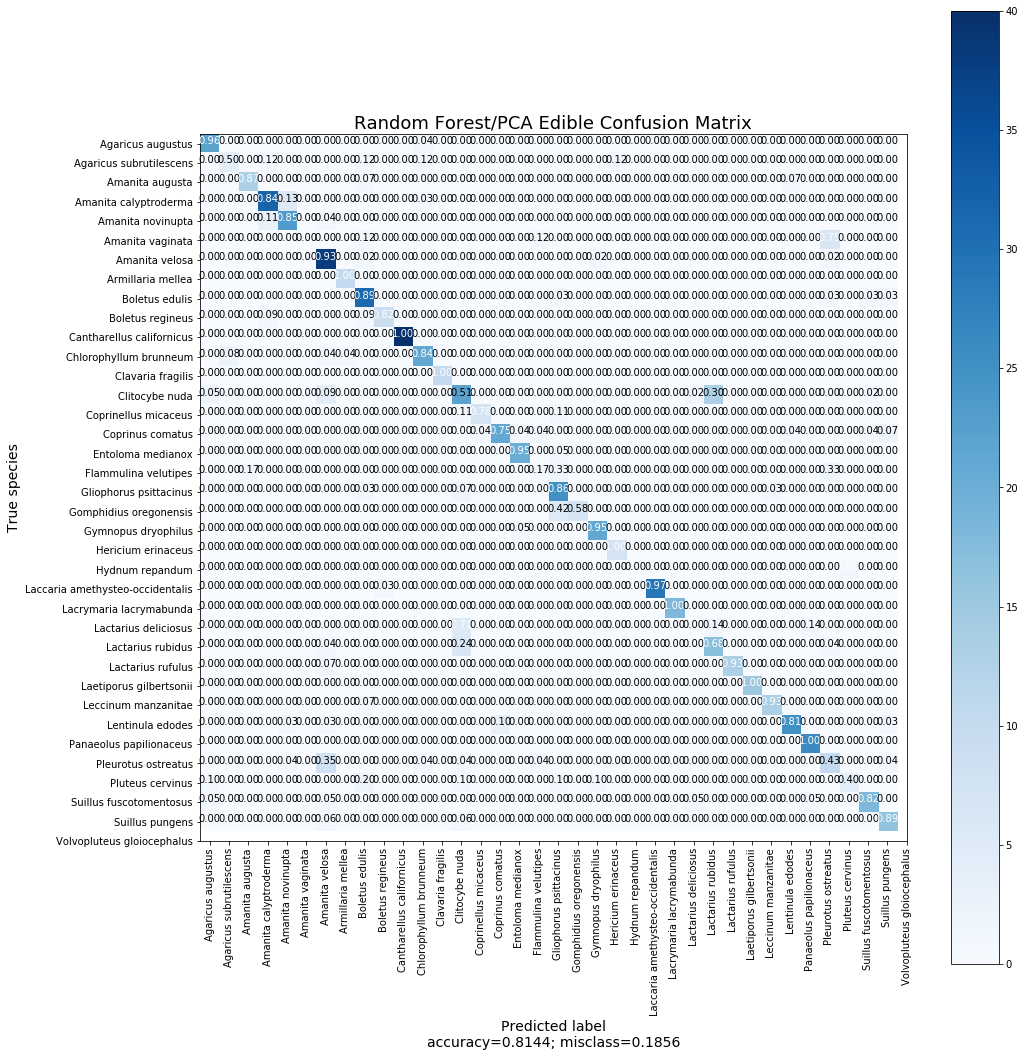

In [97]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_rf))
plot_confusion_matrix(pca_cm, mush_labels, title='Random Forest/PCA Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [98]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, rf_clf)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(688, 0.9529085872576177)

### <span style="color:white">Running SVC without PCA/SS</span>

In [99]:
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

svc = SVC(C=30.0, kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train, y_train)

SVC(C=30.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [100]:
y_preds_svc = svc.predict(X_test)
cross_val_score(svc, X_train, y_train), np.mean(cross_val_score(svc, X_train, y_train)), cross_val_score(svc, X_test, y_test), np.mean(cross_val_score(svc, X_test, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.92334495,  0.94454383,  0.95081967]),
 0.93956948271036589,
 array([ 0.7480315 ,  0.8125    ,  0.84210526]),
 0.80087891974029557)

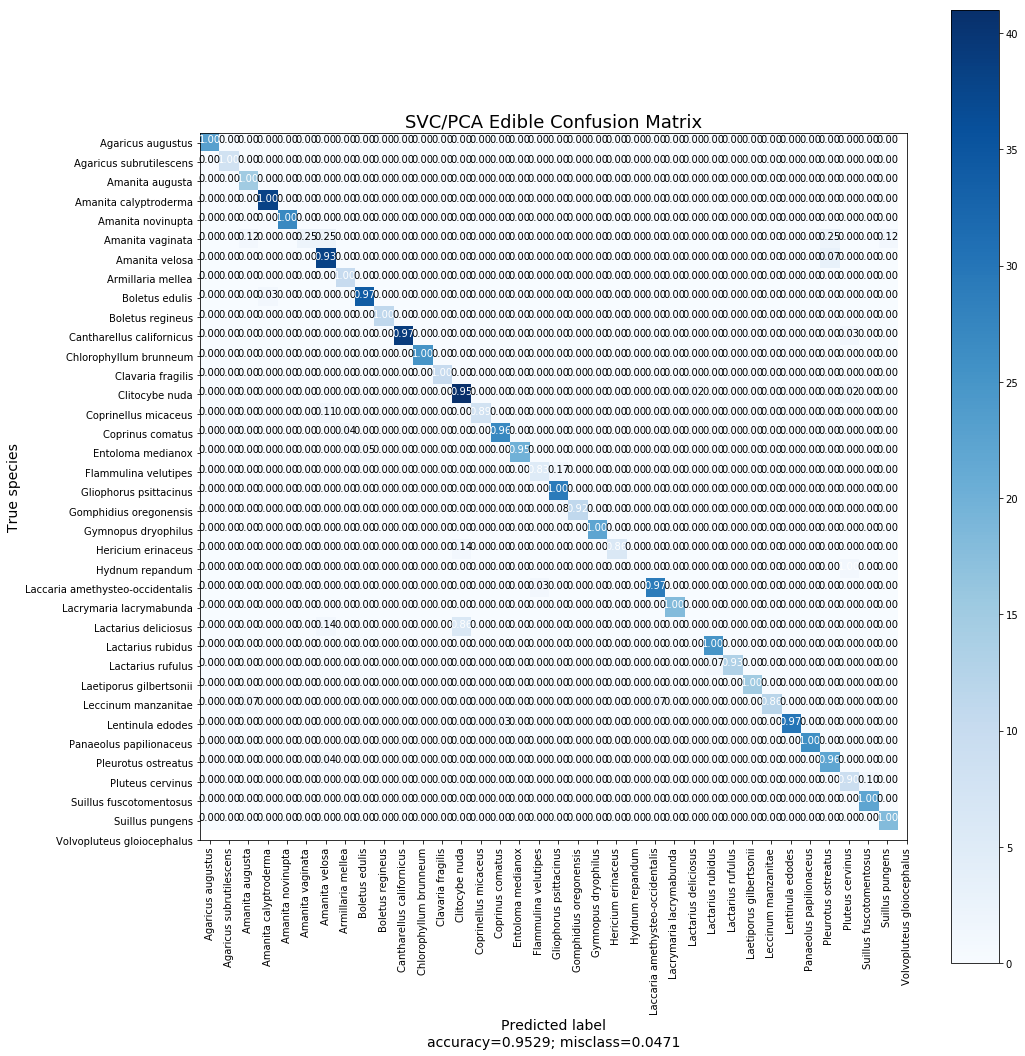

In [101]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
plot_confusion_matrix(pca_cm, mush_labels, title='SVC/PCA Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [102]:
probas_df = get_probas_from_test(X_test, X_test, svc)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(711, 0.9847645429362881)

### <span style="color:white">Running SVC with SS/PCA</span>

In [108]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster', 'stipe_scales', 'pileus_viscid', 'pileus_scales', 'pileus_warts', 'pileus_bruising'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month', 'stipe_shape', 'lamellae_morph', 'pileus_shape'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

In [109]:
X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

svc = SVC(C=20.0, kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train_ss_pca, y_train)

SVC(C=20.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_svc = svc.predict(X_test_ss_pca)
cross_val_score(svc, X_train_ss_pca, y_train), np.mean(cross_val_score(svc, X_train_ss_pca, y_train)), cross_val_score(svc, X_test_ss_pca, y_test), np.mean(cross_val_score(svc, X_test_ss_pca, y_test))

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The 

(array([ 0.67770035,  0.67620751,  0.69216758]),
 0.68202514642078338,
 array([ 0.62204724,  0.65416667,  0.71491228]),
 0.66370873048763634)

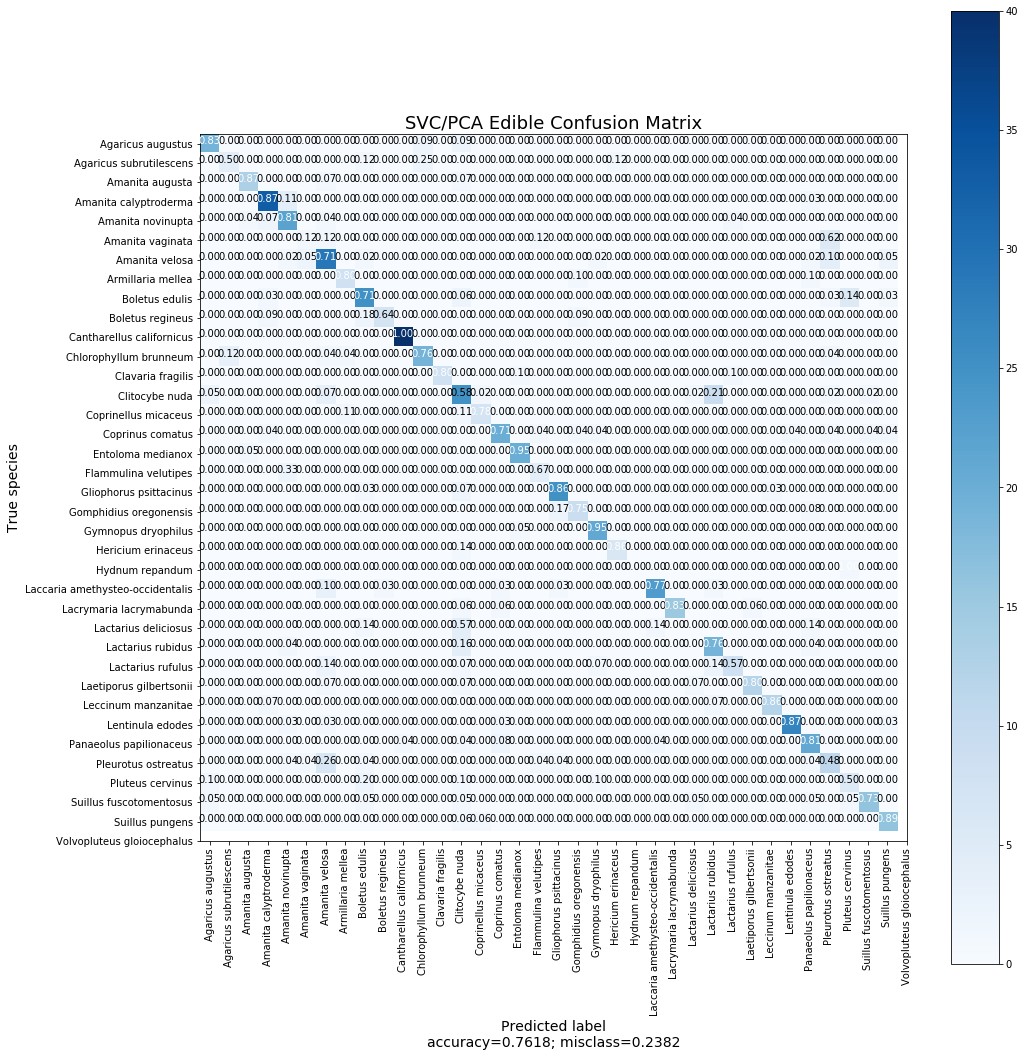

In [106]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
plot_confusion_matrix(pca_cm, mush_labels, title='SVC/PCA Edible Confusion Matrix')

### <span style="color:white">Run functions to analyze top three accuracy score</span>

In [107]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, svc)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(653, 0.9044321329639889)

## <span style="color:white">Visualizations</span>

### <span style="color:#CCC">Edible Mushrooms By Name, Cluster, and Date Found</span>

https://public.tableau.com/profile/chris.huber#!/vizhome/BayAreaEdibleMushroomsByName/EdibleMushroomsbyName

### <span style="color:#CCC">Bay Area Temperatures</span>

https://public.tableau.com/profile/chris.huber#!/vizhome/BayAreaEdibleMushrooms/WeatherConditionsByCluster?publish=yes

In [2295]:
def mushroom_count_by_year(species_list):
    species_input = '|'.join(species_list)
    # return species_input
    query = "SELECT count(bay_area_observations.id) AS mushroom_count, YEAR(bay_area_observations.created_at) AS obsv_year FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') GROUP BY obsv_year;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df    

# choice_by_year = mushroom_count_by_year(choice_mushroom_list)
edible_by_year = mushroom_count_by_year(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
# poisonous_by_year = mushroom_count_by_year(poisonous_mushroom_list)
# psychoactive_by_year = mushroom_count_by_year(psychoactive_mushroom_list)
# other_by_year = mushroom_count_by_year(other_mushroom_list)

# edible_by_year.head()

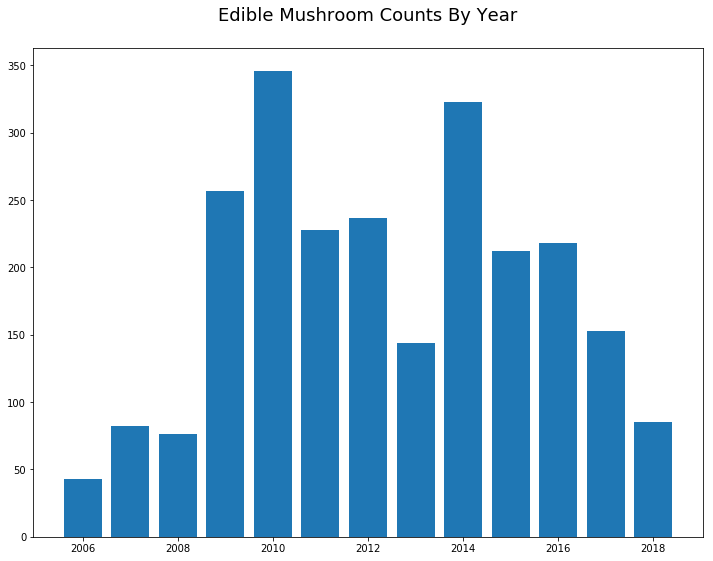

In [1755]:
def chart_mushroom_counts(mushroom_df, prefix=''):
    df = pd.DataFrame
    plt.figure(figsize=(12, 9))
    # plt.xticks(rotation=90)
    plt.title(prefix + ' Mushroom Counts By Year\n', fontsize='18', color='k')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    # df = mushroom_df.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack()
    plt.bar(mushroom_df['obsv_year'], mushroom_df['mushroom_count'])
    # plt.legend(df.columns)

chart_mushroom_counts(edible_by_year, 'Edible')

In [1211]:
# chart_mushroom_counts(poisonous_by_year, 'Poisonous')

In [1210]:
# chart_mushroom_counts(psychoactive_by_year, 'Psychoactive')

In [1209]:
# chart_mushroom_counts(other_by_year, 'Other')

### <span style="color:white">Close MySQL connection</span>

In [73]:
mysql_cn.close()